<a href="https://colab.research.google.com/github/cerean/nndl/blob/main/3c_MLP_model%E2%80%94all_experiments%E2%80%9432x4_16%E2%80%9430_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CSc 84020 Neural Networks and Deep Learning, Spring 2021
#####Homework 2
#####Andrea Ceres and Shao Liu


## Import Libraries & Load Data

#### Import libraries and define classes

In [1]:
from google.colab import drive
import glob
import os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from keras.regularizers import L2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.4.1


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
start_total_time = time.time()

In [4]:
# Different options for classes: selection to be set with constants

# critters (6 classes)
critters = ['ant', 'bee', 'butterfly', 'mosquito', 'scorpion', 
           'spider']

# birds (6 classes)
birds = ['bird', 'duck', 'flamingo', 'owl', 'parrot', 
           'penguin']

# ocean animals (8 classes)
ocean_animals = ['crab', 'dolphin', 'fish', 'lobster', 'octopus', 
           'sea%20turtle', 'shark', 'whale']

# land mammals (22 classes)
land_mammals = ['bear', 'camel', 'cat', 'cow', 'dog', 
           'elephant', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 
           'lion', 'monkey', 'mouse', 'panda', 'pig', 
           'rabbit', 'raccoon', 'rhinoceros', 'sheep', 'squirrel', 
           'tiger', 'zebra']

# all animals (47 classes) 
all_animals = ['ant', 'bat', 'bear', 'bee', 'bird', 
           'butterfly', 'camel', 'cat', 'cow', 'crab', 
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 
           'fish', 'flamingo', 'frog', 'giraffe', 'hedgehog', 
           'horse', 'kangaroo', 'lion', 'lobster', 'monkey', 
           'mosquito', 'mouse', 'octopus', 'owl', 'panda', 
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 
           'rhinoceros', 'scorpion', 'sea%20turtle', 'shark', 'sheep', 
           'snail', 'snake', 'spider', 'squirrel',  'tiger', 
           'whale', 'zebra']

#### Set constants

In [5]:
classes = critters
CLASS_SAMPLE_MAX = 25000
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/NNDL/HW2/data/'

#### Load data

In [6]:
def load_bitmaps(data_dir=DATA_DIR, class_sample_max=CLASS_SAMPLE_MAX):
    class_files = []
    for c in classes:
        print(c, end=' ')
        class_files.append(os.path.join(DATA_DIR, c + '.npy'))
    class_files.sort()
  
    X = np.empty([0,784])
    y = np.empty([0])

    print()
    for id, class_file in enumerate(class_files):
        print(id, end=' ')
        loaded_data = np.load(class_file)
        loaded_data = loaded_data[0:CLASS_SAMPLE_MAX, :]
        labels = np.full(loaded_data.shape[0],id)
        
        X = np.concatenate((X, loaded_data), axis = 0)
        y = np.append(y, labels)

    return X, y

In [7]:
start = time.time()
X, y = load_bitmaps()
print(f'\nLoading time: %.3f' % int(time.time() - start), 'seconds')
print(y[-CLASS_SAMPLE_MAX-5:-CLASS_SAMPLE_MAX+5])

ant bee butterfly mosquito scorpion spider 
0 1 2 3 4 5 
Loading time: 1.000 seconds
[4. 4. 4. 4. 4. 5. 5. 5. 5. 5.]


#### Data example

ant


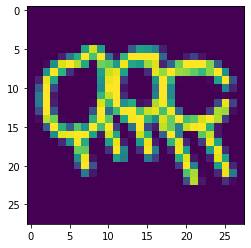

In [8]:
id = 20000
plt.imshow(X[id].reshape(28,28)) 
print(classes[int(y[id].item())])

In [9]:
X[20000]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 149., 236., 142.,   

## Normalization

In [10]:
# Normalization to range [0, 1]
X = X / 255

#### Data example after normalization

ant


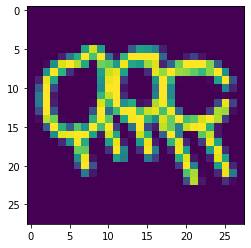

In [11]:
id = 20000
plt.imshow(X[id].reshape(28,28)) 
print(classes[int(y[id].item())])

In [12]:
X[20000]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Multi-layer Perceptron Model

#### Set constants and parameters

In [13]:
RANDOM_STATE = 84020

NUM_CLASSES = len(classes)
INPUT_DIM = X.shape[1]

TEST_SIZE = 0.1
VALIDATION_SPLIT = 0.22

VERBOSE = 0         # choose from: [0, 1]
BATCH_SIZE = 128    # choose from: [32, 64, 128]
EPOCHS = 30         # choose from: [30, 40]

In [14]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=0.001, epsilon=1e-06) 
                      # choose from: [sgd, Adam(lr=0.001, epsilon=1e-06)]

activation = LeakyReLU(alpha=0.01) # choose from: 'relu', LeakyReLU(alpha=0.01)

# dropout = 0         # choose from: [0, 0.1, 0.2, 0.4]

# l2_val = 0          # choose from: [0, 0.1, 0.0005]

loss = 'sparse_categorical_crossentropy'        
                   
metrics = ['sparse_categorical_accuracy']

#### Split X and y into train and test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=TEST_SIZE, 
                                                  shuffle=True, 
                                                  random_state=RANDOM_STATE)

In [16]:
print('Number of classes:', NUM_CLASSES)
print('Input dimension:', INPUT_DIM)
print('Total dataset \t\tX:\t', X.shape, '\t\ty:\t', y.shape)
print(100 * (1 - TEST_SIZE), '% train \t\tX_train:', X_train.shape, '\t\ty_train:',y_train.shape)
print(100 * TEST_SIZE, '% test \t\tX_test:\t', X_test.shape, '\t\ty_test:\t',y_test.shape)

Number of classes: 6
Input dimension: 784
Total dataset 		X:	 (150000, 784) 		y:	 (150000,)
90.0 % train 		X_train: (135000, 784) 		y_train: (135000,)
10.0 % test 		X_test:	 (15000, 784) 		y_test:	 (15000,)


#### Model functions

In [17]:
def build_model(dropout, l2_val, activation=activation):

    if type(activation) != str:
        activ = 'LeakyReLU'
    else:
        activ = activation

    model = Sequential(name='Multi_Layer_Perceptron_{}_{}DO_{}L2'.format(activ, dropout, l2_val))
    model.add(Input(shape=(INPUT_DIM,),
                    name='Input'))
    model.add(Dense(32, activation=activation, 
                    kernel_initializer='glorot_normal', 
                    bias_initializer='zeros',
                    kernel_regularizer=L2(l2_val),
                    name='Dense1_{}'.format(activ)))
    model.add(BatchNormalization(name='BatchNormalization1'))
    model.add(Dense(32, activation=activation, 
                    kernel_initializer='glorot_normal', 
                    bias_initializer='zeros',
                    kernel_regularizer=L2(l2_val),
                    name='Dense2_{}'.format(activ)))
    model.add(Dropout(dropout, name='Dropout_{}'.format(dropout)))
    model.add(Dense(32, activation=activation, 
                    kernel_initializer='glorot_normal', 
                    bias_initializer='zeros',
                    kernel_regularizer=L2(l2_val),
                    name='Dense3_{}'.format(activ)))
    model.add(Dense(32, activation=activation, 
                    kernel_initializer='glorot_normal', 
                    bias_initializer='zeros',
                    kernel_regularizer=L2(l2_val),
                    name='Dense4_{}'.format(activ)))
    model.add(BatchNormalization(name='BatchNormalization2'))
    model.add(Dense(16, activation=activation, 
                    kernel_initializer='glorot_normal', 
                    bias_initializer='zeros',
                    kernel_regularizer=L2(l2_val),
                    name='Dense5_{}'.format(activ)))
    model.add(Dense(NUM_CLASSES, activation='softmax',
                    name='Output'))
    
    return model

In [18]:
def compile_model(model, loss=loss, optimizer=optimizer, metrics=metrics):    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [19]:
def fit_model(model):
    start_time = time.time()
    history = model.fit(X_train, y_train, 
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_split=VALIDATION_SPLIT,
                        verbose=VERBOSE)
    time_taken = time.time() - start_time
    print(f'Total train time for {EPOCHS} epochs = %.3f' % time_taken, 'seconds\n\n')

    return history

In [20]:
def evaluate_model(model):
    score = model.evaluate(X_test, y_test, 
                           batch_size=BATCH_SIZE, 
                           verbose=VERBOSE)

    return score

In [21]:
def predict_model(model):
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

    return y_pred

In [22]:
def plot_accuracy(history, score, metrics=metrics):
    plt.plot(history.history[metrics[0]])
    plt.plot(history.history['val_'+metrics[0]])

    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.yticks(ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
    plt.show()

    print(f'Test accuracy: {score[1]:.4}\n\n')

In [23]:
def plot_loss(history, score):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    plt.legend(['Training loss', 'Validation loss'], loc='best')
    plt.show()

    print(f'Test loss: {score[0]:.4}\n\n')

In [24]:
def print_classification_report(y_pred):
    print(cr(y_test, y_pred.argmax(axis=1), target_names=classes))

In [25]:
def plot_confusion_matrix(y_pred):
    # source: https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
    cmatrix = cm(y_test, y_pred.argmax(axis=1))
    cmatrix_norm = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(cmatrix_norm, annot=True, fmt="0.3f", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Normalized confusion matrix')
    plt.show(block=False)

In [26]:
def plot_precision_recall_curve(y_pred):
    n_classes = len(classes)
    y_test_ohe = to_categorical(y_test, num_classes=NUM_CLASSES)

    # source: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
    # precision recall curve
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_ohe[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=1, label='{}'.format(classes[i]))
        
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve")
    plt.show()

In [27]:
def plot_roc_curve(y_pred):
    # source: https://stackoverflow.com/questions/64924911/plotting-multiclass-roc-curve
    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    y_test_ohe = to_categorical(y_test, num_classes=NUM_CLASSES)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw=1

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='cornflowerblue', linestyle=':', linewidth=4)

    colors = cycle(['darkgreen', 'darkorange', 'navy', 'hotpink', 'maroon', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def print_auc_scores(y_pred):
    # source:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo",
                                    average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo",
                                        average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr",
                                    average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr",
                                        average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        "(weighted by prevalence)"
        .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        "(weighted by prevalence)"
        .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

In [29]:
def plot_model_png(model, dropout, l2_val, optimizer):
    if optimizer == sgd:
        plot_path = '../MLP_sgd_'+str(dropout)+'DO_'+str(l2_val)+'L2.png'
    elif type(optimizer) != str:
        plot_path = '../MLP_adam_'+str(dropout)+'DO_'+str(l2_val)+'L2.png'
    else:
        plot_path = '../MLP_'+optimizer+'_'+str(dropout)+'DO_'+str(l2_val)+'L2.png'
    plot_model(model, to_file=os.path.join(DATA_DIR, plot_path), show_shapes=True)

In [30]:
def run_model(dropout=0, l2_val=0, activation=activation,
              loss=loss, optimizer=optimizer, metrics=metrics):
    model = build_model(dropout, l2_val, activation)
    model.summary()
    plot_model_png(model, dropout, l2_val, optimizer)
    compile_model(model)
    history = fit_model(model)
    score = evaluate_model(model)
    y_pred = predict_model(model)
    plot_accuracy(history, score)
    plot_loss(history, score)
    print_classification_report(y_pred)
    print('\n\n')
    plot_confusion_matrix(y_pred)
    print('\n\n')
    plot_precision_recall_curve(y_pred)
    print('\n\n')
    plot_roc_curve(y_pred)
    print('\n\n')
    print_auc_scores(y_pred)
    print('\n\n')

    return model, history, score, y_pred

## Run models



Model: "Multi_Layer_Perceptron_LeakyReLU_0DO_0L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (Batch

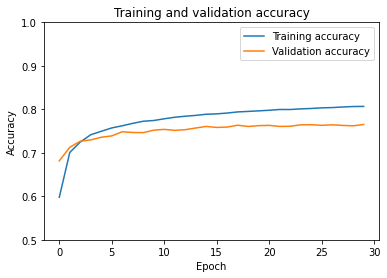

Test accuracy: 0.7641




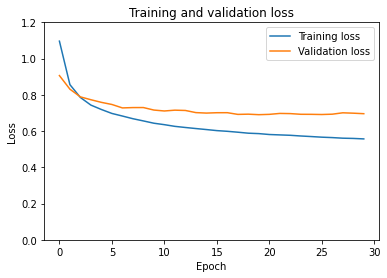

Test loss: 0.6984


              precision    recall  f1-score   support

         ant       0.68      0.75      0.71      2478
         bee       0.75      0.78      0.76      2488
   butterfly       0.89      0.88      0.89      2557
    mosquito       0.62      0.63      0.63      2527
    scorpion       0.84      0.79      0.81      2468
      spider       0.81      0.76      0.79      2482

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.77     15000






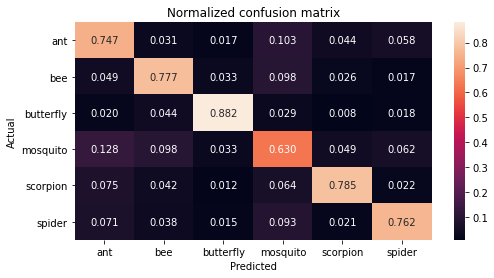

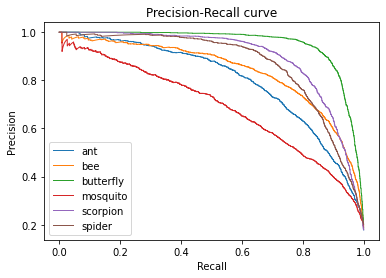

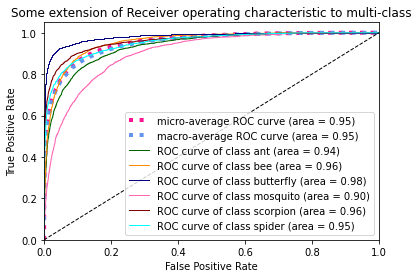




One-vs-One ROC AUC scores:
0.948369 (macro),
0.948412 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.948432 (macro),
0.948461 (weighted by prevalence)





In [31]:
model_base, history_base, score_base, y_pred_base = run_model()

Model: "Multi_Layer_Perceptron_LeakyReLU_0.1DO_0L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.1 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (Bat

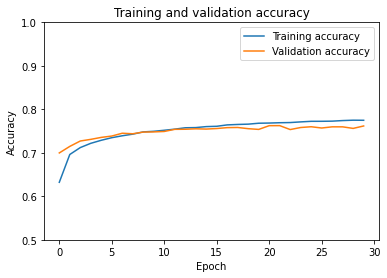

Test accuracy: 0.7571




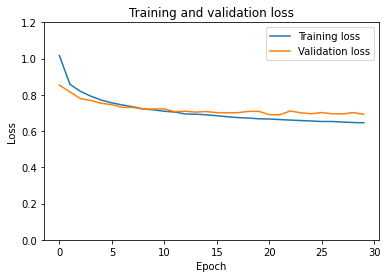

Test loss: 0.6967


              precision    recall  f1-score   support

         ant       0.71      0.70      0.70      2478
         bee       0.72      0.80      0.75      2488
   butterfly       0.87      0.90      0.88      2557
    mosquito       0.62      0.63      0.62      2527
    scorpion       0.82      0.79      0.81      2468
      spider       0.82      0.72      0.77      2482

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000






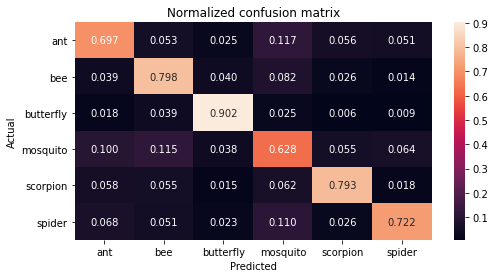

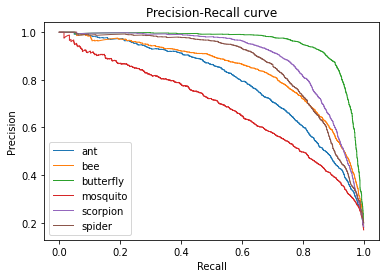

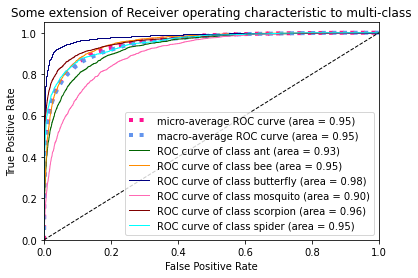




One-vs-One ROC AUC scores:
0.946891 (macro),
0.946948 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.946973 (macro),
0.947013 (weighted by prevalence)





In [32]:
model_10do, history_10do, score_10do, y_pred_10do = run_model(dropout=0.1)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.2DO_0L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.2 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (Bat

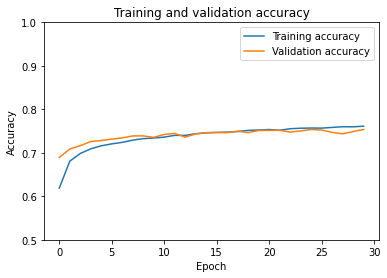

Test accuracy: 0.7538




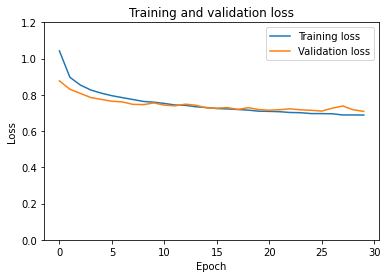

Test loss: 0.7123


              precision    recall  f1-score   support

         ant       0.71      0.69      0.70      2478
         bee       0.72      0.79      0.75      2488
   butterfly       0.88      0.88      0.88      2557
    mosquito       0.60      0.63      0.62      2527
    scorpion       0.82      0.79      0.80      2468
      spider       0.81      0.74      0.77      2482

    accuracy                           0.75     15000
   macro avg       0.76      0.75      0.75     15000
weighted avg       0.76      0.75      0.75     15000






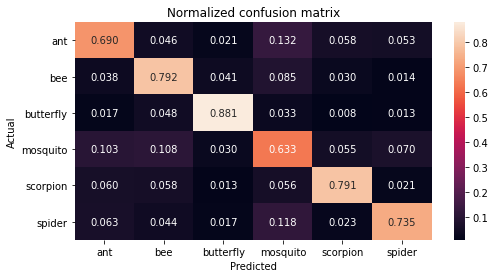

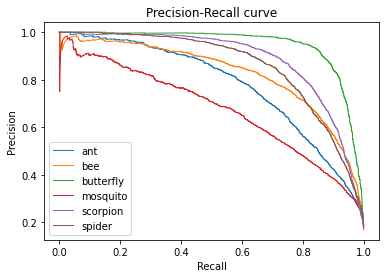

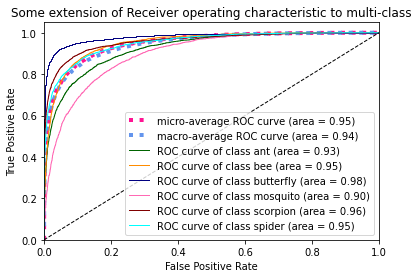




One-vs-One ROC AUC scores:
0.944132 (macro),
0.944187 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.944211 (macro),
0.944251 (weighted by prevalence)





In [33]:
model_20do, history_20do, score_20do, y_pred_20do = run_model(dropout=0.2)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.4DO_0L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.4 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (Bat

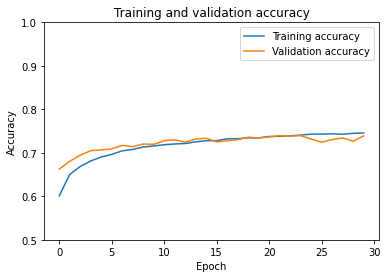

Test accuracy: 0.7375




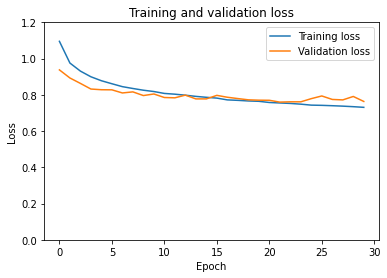

Test loss: 0.7637


              precision    recall  f1-score   support

         ant       0.65      0.69      0.67      2478
         bee       0.71      0.75      0.73      2488
   butterfly       0.90      0.86      0.88      2557
    mosquito       0.59      0.65      0.62      2527
    scorpion       0.79      0.78      0.79      2468
      spider       0.83      0.68      0.75      2482

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000






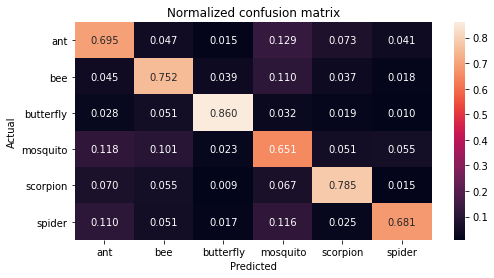

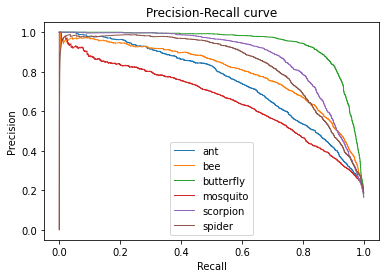

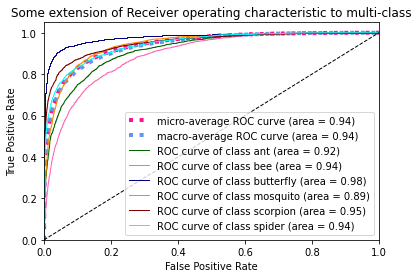




One-vs-One ROC AUC scores:
0.938007 (macro),
0.938062 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.938068 (macro),
0.938130 (weighted by prevalence)





In [34]:
model_40do, history_40do, score_40do, y_pred_40do = run_model(dropout=0.4)

Model: "Multi_Layer_Perceptron_LeakyReLU_0DO_0.0005L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (

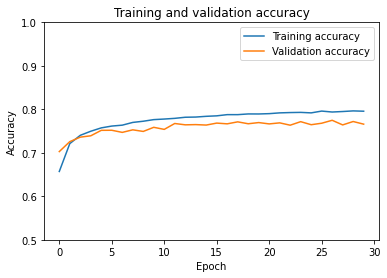

Test accuracy: 0.7613




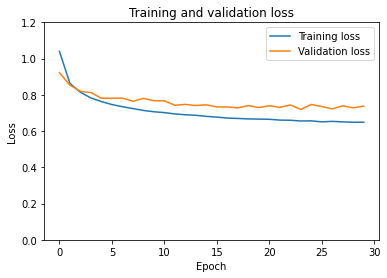

Test loss: 0.744


              precision    recall  f1-score   support

         ant       0.76      0.65      0.70      2478
         bee       0.73      0.78      0.76      2488
   butterfly       0.92      0.86      0.89      2557
    mosquito       0.62      0.66      0.64      2527
    scorpion       0.72      0.87      0.79      2468
      spider       0.86      0.74      0.79      2482

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.76     15000






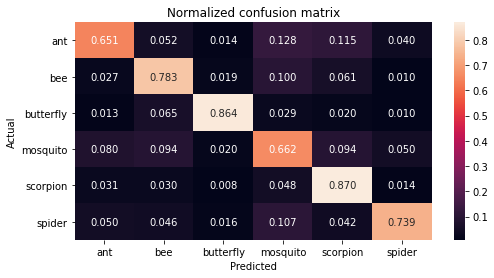

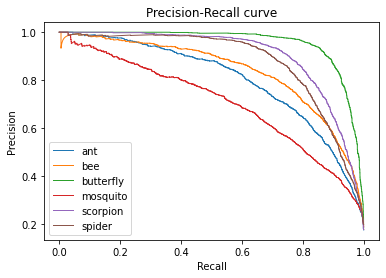

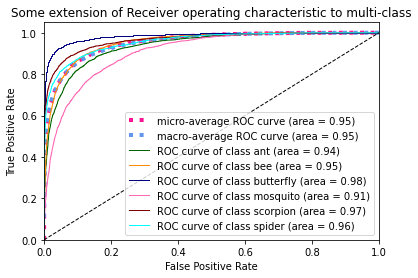




One-vs-One ROC AUC scores:
0.951254 (macro),
0.951290 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.951299 (macro),
0.951332 (weighted by prevalence)





In [35]:
model_0005L2, history_0005L2, score_0005L2, y_pred_0005L2 = run_model(l2_val=0.0005)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.1DO_0.0005L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.1 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2

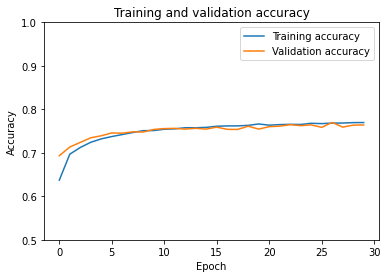

Test accuracy: 0.7588




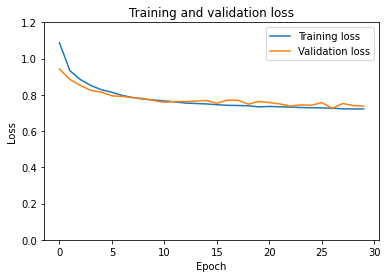

Test loss: 0.7538


              precision    recall  f1-score   support

         ant       0.73      0.68      0.70      2478
         bee       0.73      0.78      0.76      2488
   butterfly       0.90      0.87      0.89      2557
    mosquito       0.60      0.67      0.64      2527
    scorpion       0.85      0.77      0.81      2468
      spider       0.77      0.78      0.77      2482

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000






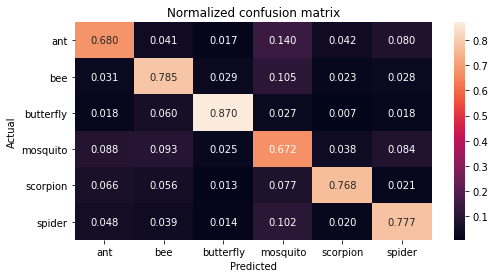

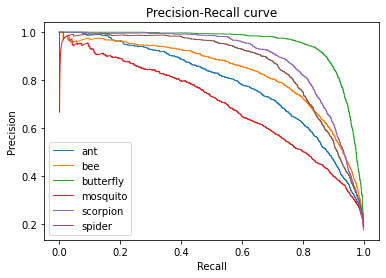

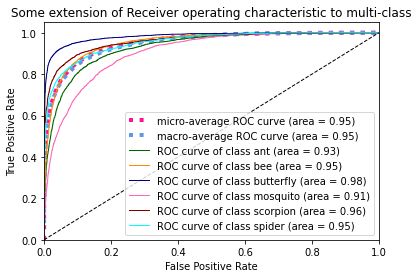




One-vs-One ROC AUC scores:
0.947766 (macro),
0.947825 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.947850 (macro),
0.947892 (weighted by prevalence)





In [36]:
model_0005L2_10do, history_0005L2_10do, score_0005L2_10do, y_pred_0005L2_10do = run_model(l2_val=0.0005, dropout=0.1)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.2DO_0.0005L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.2 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2

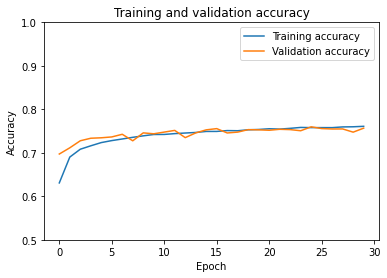

Test accuracy: 0.7559




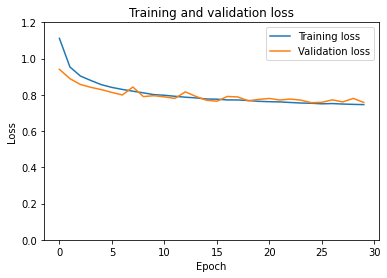

Test loss: 0.7577


              precision    recall  f1-score   support

         ant       0.72      0.67      0.70      2478
         bee       0.74      0.78      0.76      2488
   butterfly       0.94      0.82      0.88      2557
    mosquito       0.59      0.69      0.64      2527
    scorpion       0.80      0.81      0.80      2468
      spider       0.79      0.75      0.77      2482

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000






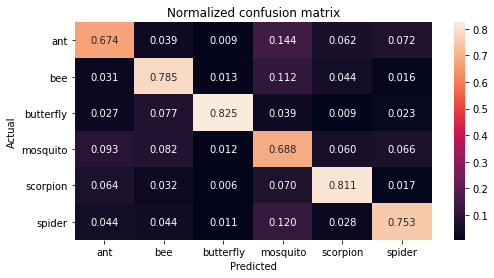

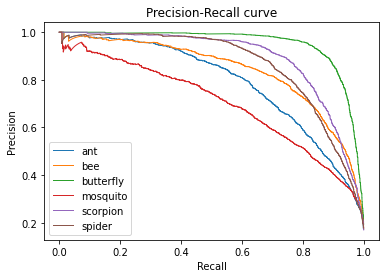

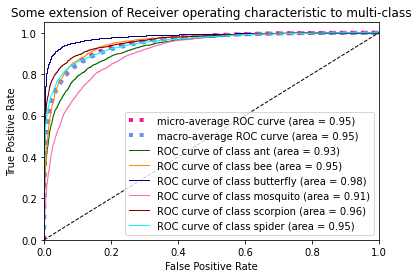




One-vs-One ROC AUC scores:
0.947502 (macro),
0.947534 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.947521 (macro),
0.947577 (weighted by prevalence)





In [37]:
model_0005L2_20do, history_0005L2_20do, score_0005L2_20do, y_pred_0005L2_20do = run_model(l2_val=0.0005, dropout=0.2)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.4DO_0.0005L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.4 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2

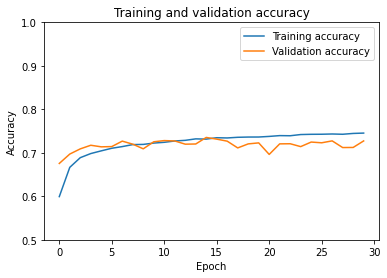

Test accuracy: 0.7245




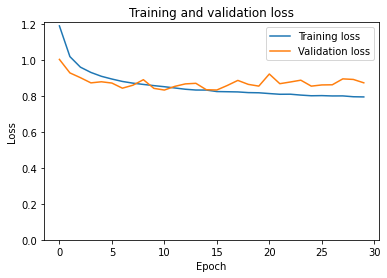

Test loss: 0.8783


              precision    recall  f1-score   support

         ant       0.66      0.68      0.67      2478
         bee       0.66      0.80      0.72      2488
   butterfly       0.96      0.75      0.84      2557
    mosquito       0.56      0.68      0.61      2527
    scorpion       0.88      0.69      0.77      2468
      spider       0.76      0.75      0.76      2482

    accuracy                           0.72     15000
   macro avg       0.75      0.72      0.73     15000
weighted avg       0.75      0.72      0.73     15000






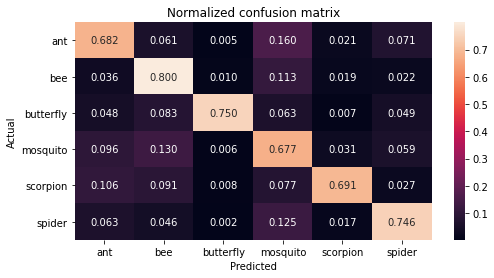

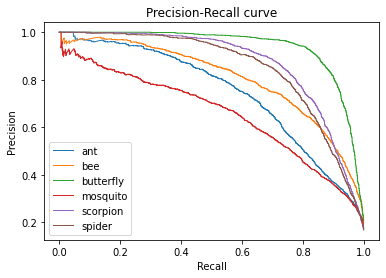

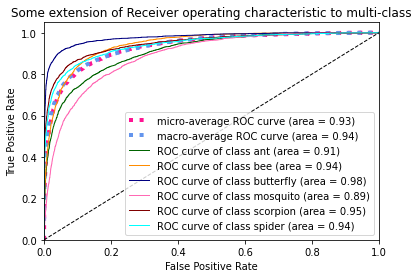




One-vs-One ROC AUC scores:
0.935029 (macro),
0.935063 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.935038 (macro),
0.935112 (weighted by prevalence)





In [38]:
model_0005L2_40do, history_0005L2_40do, score_0005L2_40do, y_pred_0005L2_40do = run_model(l2_val=0.0005, dropout=0.4)

Model: "Multi_Layer_Perceptron_LeakyReLU_0DO_0.01L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (Ba

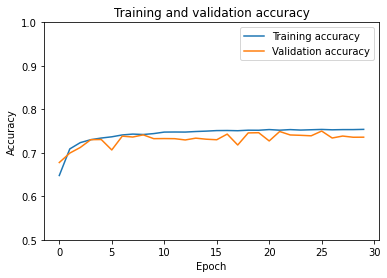

Test accuracy: 0.7371




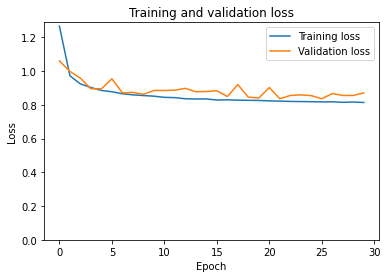

Test loss: 0.8738


              precision    recall  f1-score   support

         ant       0.74      0.62      0.68      2478
         bee       0.60      0.87      0.71      2488
   butterfly       0.86      0.88      0.87      2557
    mosquito       0.68      0.53      0.60      2527
    scorpion       0.79      0.79      0.79      2468
      spider       0.81      0.72      0.76      2482

    accuracy                           0.74     15000
   macro avg       0.75      0.74      0.73     15000
weighted avg       0.75      0.74      0.73     15000






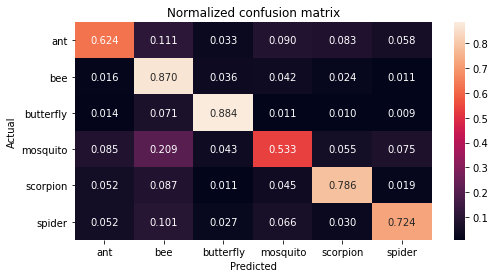

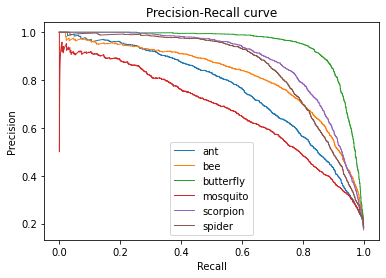

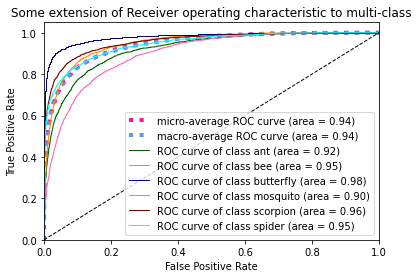




One-vs-One ROC AUC scores:
0.941489 (macro),
0.941559 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.941585 (macro),
0.941641 (weighted by prevalence)





In [39]:
model_01L2, history_01L2, score_01L2, y_pred_01L2 = run_model(l2_val=0.01)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.1DO_0.01L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.1 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (

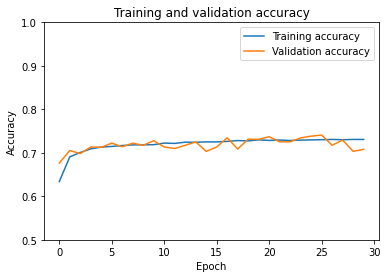

Test accuracy: 0.7078




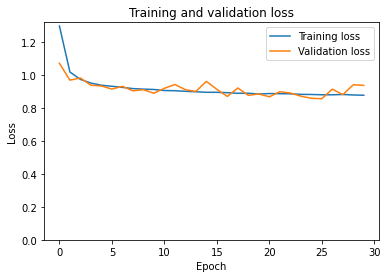

Test loss: 0.932


              precision    recall  f1-score   support

         ant       0.58      0.71      0.64      2478
         bee       0.75      0.70      0.73      2488
   butterfly       0.82      0.89      0.85      2557
    mosquito       0.59      0.58      0.58      2527
    scorpion       0.71      0.80      0.75      2468
      spider       0.89      0.56      0.69      2482

    accuracy                           0.71     15000
   macro avg       0.72      0.71      0.71     15000
weighted avg       0.72      0.71      0.71     15000






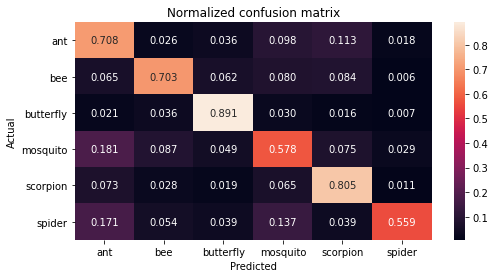

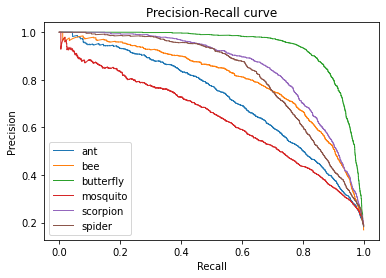

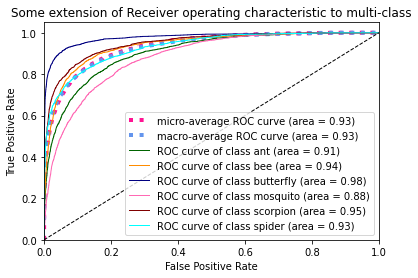




One-vs-One ROC AUC scores:
0.930512 (macro),
0.930593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.930607 (macro),
0.930690 (weighted by prevalence)





In [40]:
model_01L2_10do, history_01L2_10do, score_01L2_10do, y_pred_01L2_10do = run_model(l2_val=0.01, dropout=0.1)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.2DO_0.01L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.2 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (

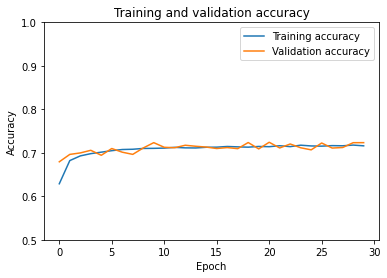

Test accuracy: 0.722




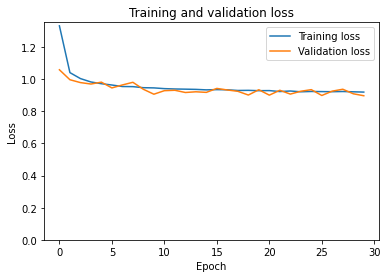

Test loss: 0.9059


              precision    recall  f1-score   support

         ant       0.64      0.65      0.64      2478
         bee       0.72      0.70      0.71      2488
   butterfly       0.90      0.81      0.86      2557
    mosquito       0.55      0.70      0.61      2527
    scorpion       0.81      0.76      0.78      2468
      spider       0.80      0.70      0.75      2482

    accuracy                           0.72     15000
   macro avg       0.74      0.72      0.73     15000
weighted avg       0.74      0.72      0.73     15000






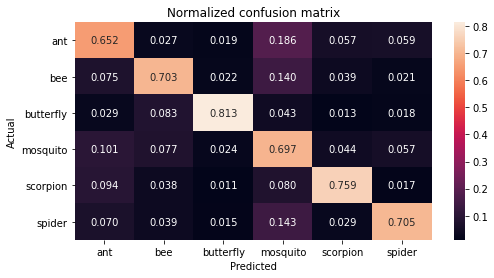

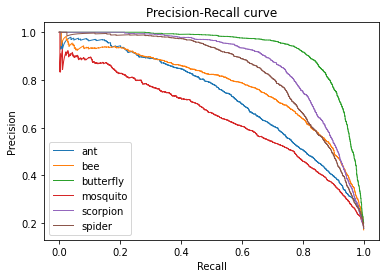

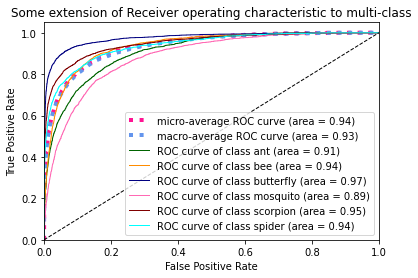




One-vs-One ROC AUC scores:
0.932608 (macro),
0.932666 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.932675 (macro),
0.932737 (weighted by prevalence)





In [41]:
model_01L2_20do, history_01L2_20do, score_01L2_20do, y_pred_01L2_20do = run_model(l2_val=0.01, dropout=0.2)

Model: "Multi_Layer_Perceptron_LeakyReLU_0.4DO_0.01L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1_LeakyReLU (Dense)     (None, 32)                25120     
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 32)                128       
_________________________________________________________________
Dense2_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dropout_0.4 (Dropout)        (None, 32)                0         
_________________________________________________________________
Dense3_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
Dense4_LeakyReLU (Dense)     (None, 32)                1056      
_________________________________________________________________
BatchNormalization2 (

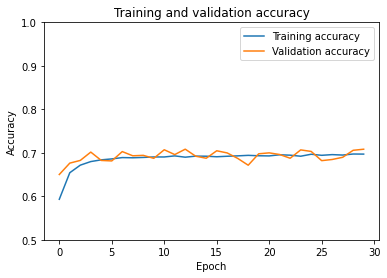

Test accuracy: 0.7068




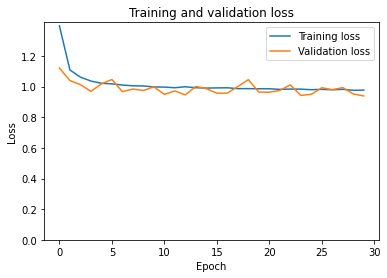

Test loss: 0.9366


              precision    recall  f1-score   support

         ant       0.68      0.59      0.63      2478
         bee       0.64      0.75      0.69      2488
   butterfly       0.84      0.85      0.85      2557
    mosquito       0.56      0.62      0.59      2527
    scorpion       0.83      0.73      0.78      2468
      spider       0.73      0.69      0.71      2482

    accuracy                           0.71     15000
   macro avg       0.71      0.71      0.71     15000
weighted avg       0.71      0.71      0.71     15000






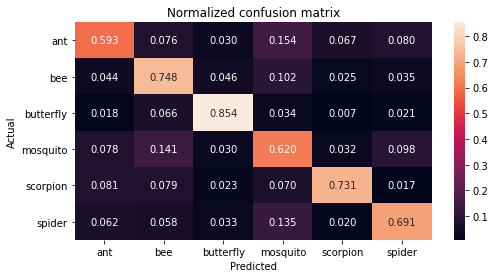

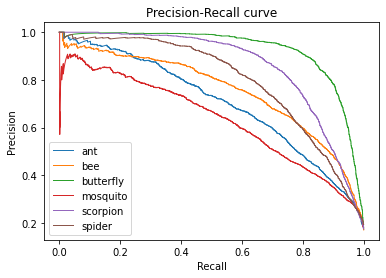

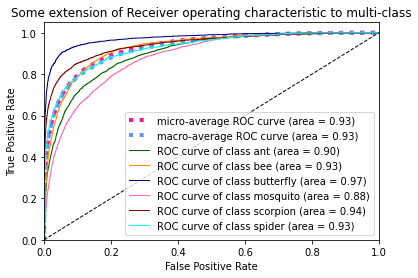




One-vs-One ROC AUC scores:
0.925344 (macro),
0.925445 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.925465 (macro),
0.925565 (weighted by prevalence)





In [42]:
model_01L2_40do, history_01L2_40do, score_01L2_40do, y_pred_01L2_40do = run_model(l2_val=0.01, dropout=0.4)

### Time taken

In [43]:
total_time = (time.time() - start_total_time) / 60
print(f"Total time %.3f" % total_time, "minutes")

Total time 15.270 minutes
